# data marshalling

first, we'll need a method to find recordings by subject ID and task name

we'll also produce a list `subject_ids` of all subjects, and `task_names` of all tasks.


In [1]:
import os
files = os.listdir('data')

def subject_id (filename):
    return filename.split('.')[0]

def task_name (filename):
    return filename.split('.')[1]

subject_ids = list(set(map(subject_id, files)))
task_names = list(set(map(task_name, files)))


In [2]:

def find_with_id (id):
    return lambda filename: subject_id(filename) == id

def find_with_task (task):
    return lambda filename: task_name(filename) == task

# both args are optional
def find_recordings (id=None, task=None):
    lst = files
    if id:
        lst = list(filter(find_with_id(id), lst))
    if task:
        lst = list(filter(find_with_task(task), lst))
    return lst

find_recordings(task='breathe_o')
find_recordings('002', 'breathe_o')

['002.breathe_o.1478914139385.csv',
 '002.breathe_o.1478915038323.csv',
 '002.breathe_o.1478915049512.csv',
 '002.breathe_o.1478915025849.csv',
 '002.breathe_o.1478914092279.csv',
 '002.breathe_o.1478914127598.csv',
 '002.breathe_o.1478915002519.csv',
 '002.breathe_o.1478914104820.csv',
 '002.breathe_o.1478915013777.csv',
 '002.breathe_o.1478914116257.csv']

now, we will want positive and negative examples for training. 

for a given subject and task, we need examples of the correct person performing the task (positive examples), and examples of the incorrect person performing the task (negative examples).

but, first, we will need to create some feature vectors. let's load up a file and look at it.


In [3]:
%pylab inline
import pandas as pd
from os.path import join

def load_recording (filename):
    df = pd.read_csv(join('data', filename), header=None)
    return df.drop(df.columns[[0,2,3,4,5,7]], 1)  # drop all columns but 1 and 6

#load_reading(files[3])


Populating the interactive namespace from numpy and matplotlib


In [4]:
import itertools
from scipy.interpolate import interp1d
from functools import partial

def grouper (n, iterable):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return list(itertools.zip_longest(*args))[:-1]

def spectrum (vector):
    '''get the power spectrum of a vector of raw EEG data'''
    A = np.fft.fft(vector)
    ps = np.abs(A)*2.0
    ps = ps[:len(ps)//2]
    return ps

def binned (pspectra, n):
    '''compress an array of power spectra into vectors of length n'''
    l = len(pspectra)
    array = np.zeros([l,n])
    for i,ps in enumerate(pspectra):
        x = np.arange(1,len(ps)+1)
        f = interp1d(x,ps)#/np.sum(ps))
        array[i] = f(np.arange(1, n+1))
    index = np.argwhere(array[:,0]==-1)
    array = np.delete(array,index,0)
    return array

def feature_vector (bins, readings): # A function we apply to each group of power spectra
  '''
  Create 100, log10-spaced bins for each power spectrum.
  For more on how this particular implementation works, see:
      http://people.ischool.berkeley.edu/~chuang/pubs/MMJC15.pdf
  '''
  bins = binned(list(map(spectrum, readings)),
                bins)
  return np.log10(np.mean(bins, 0))

def features (raws, bins=50, time_resolution=250, spectra_compression=2 ):
    featureVectorF = partial(feature_vector, bins)
    spectra = map(spectrum, grouper(time_resolution, raws))
    groupedSpectra = grouper(spectra_compression, spectra)
    vs = list(map(featureVectorF, groupedSpectra))
    return np.array(vs)

breathe = load_recording(
    find_recordings(task='breathe')[0])

features(breathe[1], bins=25, spectra_compression=1).shape


(8, 25)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
def cross_val_svm (X,y,n):
    clf = svm.SVC()
    scores = cross_val_score(clf, X, y, cv=n)
    return scores    

def vectors_labels (list1, list2):
    def label (l):
        return lambda x: l
    X = np.concatenate([list1, list2])
    y = np.array(list(map(label(0), list1)) + list(map(label(1), list2)))
    return X, y


max_sport = load_recording(
          find_recordings(id="001", task='sport')[0])
john_sport = load_recording(
           find_recordings(id="002", task='sport')[0])

X, y = vectors_labels(
    features(max_sport[1]),
    features(john_sport[1]))

cross_val_svm(X,y,2)


array([ 1.,  1.])

In [6]:
from functools import reduce

t_res = 400
bns   = t_res//4
cmprs = 1

def featureify (acc, df, bins=bns, time_res=t_res, spectra_compress=cmprs):
    f = lambda df, n: features(df[n],
                               bins=bins,
                               time_resolution=time_res,
                               spectra_compression=spectra_compress)
    elec1 = f(df, 1)
    elec6 = f(df, 6)
    return acc + np.concatenate([elec1,elec6], 1).tolist()
    #return acc + elec1.tolist()

def vectors (filenames):
    return np.array(reduce(featureify,
                  # a list of dataframes of recordings
                  map(load_recording, filenames),
                  []))

def load_feature_vectors(id=None, task=None):
    return vectors(find_recordings(id, task))

breathe_features = load_feature_vectors(id='001', task='breathe')

np.array(breathe_features).shape


(50, 200)

In [7]:
# here's a realy simple test of authentication power
from sklearn import preprocessing

scaler  = preprocessing.RobustScaler()
max_breathe = load_feature_vectors(id='001', task='breathe')
john_breathe = load_feature_vectors(id='002', task='breathe')
X = scaler.fit_transform(X)
X, y = vectors_labels(max_breathe, john_breathe)
cv = cross_val_svm(X,y,7)
(cv.mean(),cv.std())


(1.0, 0.0)

,test-auc-mean,test-auc-std,test-map-mean,test-map-std,train-auc-mean,train-auc-std,train-map-mean,train-map-std
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


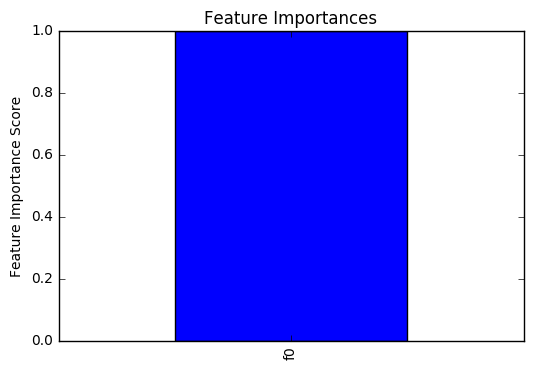

In [8]:
# here's a fancier version of above using xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#from sklearn.grid_search impo

# eval_metrics:
# http://xgboost.readthedocs.io/en/latest//parameter.html
metrics = ['auc', 'map']

def cv (alg,X,y,nfold=7):
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=50)
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

def inspect (alg):
    #Predict training set:
    #dtrain_predictions = alg.predict(X)
    #dtrain_predprob = alg.predict_proba(X)[:,1]
    ##Print model report:
    #print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    features = alg.booster().get_fscore()
    feat_imp = pd.Series(features).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


def fresh_xgb ():
    return XGBClassifier(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread=4,
         scale_pos_weight=1,
         seed=27) 

X, y = vectors_labels(
    max_breathe,
    john_breathe)

alg, cvresults = cv(fresh_xgb(), X,y)
inspect(alg)
# see result of last cv round
cvresults[-1:]



In [9]:
# returns FAR, FRR
def far_frr (alg, X, y):
    false_accept = 0
    false_reject = 0
    predicted_labels = alg.predict(X)
    for idx, predicted_label in enumerate(predicted_labels):
        correct_label = y[idx]
        if (predicted_label==correct_label):
           continue
        elif (predicted_label==0):
           false_accept+=1
           continue
        false_reject+=1
    def rate (num):
        return num/len(X)
    return { 'FAR': rate(false_accept),
             'FRR': rate(false_reject) }

alg, cvresults = cv(fresh_xgb(), X,y)
far_frr(alg, X, y)


{'FAR': 0.0, 'FRR': 0.0}

In [10]:
def difference (a, b):
    return list(set(b) - set(a))

difference([1,2,3], [1,2,3,4,5])


[4, 5]

In [11]:
def withold_final (percent, lst):
    n = int(len(lst)*percent)
    return lst[:-1*n, :]
withold_final(0.4,
              np.array([[1,0],[2,0],[3,0],[4,0],[5,0]]))
def get_final (percent, lst):
    n = int(len(lst)*percent)
    return lst[-1*n:, :]
get_final(0.4,
          np.array([[1,0],[2,0],[3,0],[4,0],[5,0]]))



array([[4, 0],
       [5, 0]])

In [15]:
def test_auth (task, percent_to_withold=0, against_all_tasks=False):

    def apply_if_witholding (f, vectors):
        if (percent_to_withold):
            return f(percent_to_withold, vectors)
        return vectors

    def trainset (vectors):
        return apply_if_witholding(withold_final, vectors)

    def testset (vectors):
        return apply_if_witholding(get_final, vectors)

    # get `task` by this `subject`
    # HACK just using subj 1 for now
    this_persons_features =  load_feature_vectors('001', task)

    # we can test against only this task from others
    if not against_all_tasks:
        # get `task` NOT from this `subject`
        not_this_persons_features =  load_feature_vectors('002', task=task)  

    # or against all tasks from others
    elif against_all_tasks:
        this_persons_recordings = find_recordings('001')
        not_this_persons_recordings = difference(this_persons_recordings, files)
        not_this_persons_features = vectors(not_this_persons_recordings)

    # turn these pos/neg features into vectors, labels X, y
    trainX, trainy = vectors_labels(trainset(this_persons_features),
                                    trainset(not_this_persons_features))

    #print('training matrix',trainX.shape)

    # fit an alg over 7 cv rounds
    alg, cvresults = cv(fresh_xgb(),
                        trainX, trainy,
                        nfold=7)

    # turn these pos/neg features into vectors, labels X, y
    testX, testy= vectors_labels(testset(this_persons_features),
                                 testset(not_this_persons_features))
    # get far, frr
    return far_frr(alg, testX, testy)

test_auth(task_names[2],
          against_all_tasks=True)


{'FAR': 0.0, 'FRR': 0.0}

In [17]:
'''
when I do 

    for task in task_names:
        print(task, test_auth(task))

the results are perfect...........too perfect
I think we are overfitting.

its confusing, but in the cv round, we are doing 7 rounds of cv to generate some parameters
then, we fit those parameters to the algorithm, and return it
so, when we test on that same data later, we are effectively testing on the train set,
since the paramaters were generated from there.


as a simple (dumb) solution, lets withold the last n samples of each group (positive, negative) for testing
'''

stats = ['FAR','FRR']
df = pd.DataFrame(columns=['task'] + stats)

for idx, task in enumerate(task_names):
    print('running', task)
    results = test_auth(task,
                        percent_to_withold=0.7,       # percent to withold per group (pos/neg)
                        against_all_tasks=True)       # use all task types as negative examples
    results_stats = [results[stat] for stat in stats]
    row = [task]+results_stats
    df.loc[idx] = row
    #df.append(row)

df

running listennoise
running breathe_o
running listentone
running sequence
running face
running song
running breathe
running speech
running sport
running song_o


,task,FAR,FRR
0,listennoise,0.0,0.0
1,breathe_o,0.0,0.0
2,listentone,0.0,0.0
3,sequence,0.0,0.0
4,face,0.0,0.0
5,song,0.0,0.0
6,breathe,0.0,0.0
7,speech,0.0,0.0
8,sport,0.0,0.0
9,song_o,0.0,0.0


In [285]:
df.to_csv('n-of-2-results_against-all.csv')